In [46]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from basic_utils import *
from valuation import *

pd.set_option('display.max_rows', 20)

In [2]:
dates = read_dates('quote')
UNIT_SCALE = 10**9
date_cols = ['endDate', 'storeDate']
excl_cols = ['maxAge', 'symbol', 'period', 'storeDate']

In [3]:
tgt_date = [dates[-1]] # hardcoded for now
tgt_date

['2019-02-15']

### Load data from S3

In [107]:
latest_quotes = load_csvs('quote_consol', tgt_date)
latest_quotes.set_index('symbol', drop=False, inplace=True)
profile = load_csvs('summary_detail', ['assetProfile'])
latest_keystats = load_csvs('summary_detail', ['defaultKeyStatistics/' + str(tgt_date[0])])
latest_finstats = load_csvs('summary_detail', ['financialData/' + str(tgt_date[0])])

Loading file quote/csv/2019-02-15
Loading file summary-categories/assetProfile
Loading file summary-categories/defaultKeyStatistics/2019-02-15
Loading file summary-categories/financialData/2019-02-15


In [112]:
rates = ["^IRX", "^FVX", "^TNX", "^TYX"]
FXs = latest_quotes[(latest_quotes.quoteType == 'CURRENCY')]
base_rate_symbol = "^TNX"
base_rate = latest_quotes.loc[base_rate_symbol,:].regularMarketPrice / 100
risk_premium = 500 / 10000
proj_increase = 50 / 10000
growth_cap_factor = 0.3
growth_discount_premium = 1
discount_rate = base_rate + risk_premium + proj_increase

In [179]:
key_cols = ['totalAssets','adjAssetBaseLessCash', 'netDebt',
   'totalRevenue', 'steadyCF', 'steadyFCF', 'reinvCapital',
   'ROA', 'ROE', 'AT', 'AAT']

In [108]:
latest_finBS = load_csvs('summary_detail', ['financials-BS'])
latest_finIS = load_csvs('summary_detail', ['financials-IS'])
latest_finCF = load_csvs('summary_detail', ['financials-CF'])

Loading file summary-categories/financials-BS
Loading file summary-categories/financials-IS
Loading file summary-categories/financials-CF


In [109]:
# convert timestamps to dates
latest_finBS = convert_dates(latest_finBS, date_cols, 'endDate')
latest_finIS = convert_dates(latest_finIS, date_cols, 'endDate')
latest_finCF = convert_dates(latest_finCF, date_cols, 'endDate')

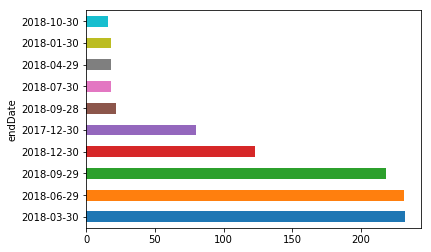

In [110]:
# show distribution of filling dates for the universe
field = 'cash'
fil_period = latest_finBS[(latest_finBS.period == 'Q')]
date_count_df = fil_period.groupby(
    fil_period.index).count().sort_values(
        by=field, ascending=False).head(10)
date_count_df[field].plot.barh();

### Select company

In [206]:
symbol = 'BABA'
key_stats_df = latest_keystats[latest_keystats.symbol == symbol]
fin_stats_df = latest_finstats[latest_finstats.symbol == symbol]
quote_df = latest_quotes[latest_quotes.symbol == symbol]

### Perform analysis

In [207]:
# valuation utility functions
non_empty = lambda df: df[[y for x, y in zip(~df.isna().iloc[0].values, df.columns.tolist()) if x == True]]

def clean_ltm(ds, symbol, filterCol, isBs):
    # appends most recent quarter or last four quarters to historical financials
    df = ds[ds.symbol == symbol]
    df = df.dropna(subset=[filterCol]).sort_index()
    df = fs_append_ltm(df[df.period == 'A'], df[df.period == 'Q'], isBs, excl_cols)
    return df    

def cagr_series(val_df):
    years = (val_df.index[-1] - val_df.index[0]).days / 365
    return pow(val_df.iloc[-1] / val_df.iloc[0], (1 / years)) - 1    

def get_BS_metrics(symbol):
    # calculate adjusted asset base for valuation
    df = clean_ltm(latest_finBS, symbol, 'cash', True)
    # print_labels("BS", df)
    wc_assets = ['netReceivables', 'inventory']
    wc_liabs = ['accountsPayable']
    total_cash = ['cash', 'shortTermInvestments', 'longTermInvestments']
    total_debt = ['shortLongTermDebt', 'longTermDebt']
    summary = ['totalAssets', 'workingCapital', 'adjAssetBase',
                  'totalCash', 'adjAssetBaseLessCash', 'netDebt']
    
    df.loc[:, 'workingCapital'] = fs_total_subset(df, wc_assets) - fs_total_subset(df, wc_liabs)
    df.loc[:, 'adjAssetBase'] = df['totalAssets'] + df['workingCapital'].apply(min, args=(0,))
    df.loc[:, 'totalCash'] = fs_total_subset(df, total_cash)
    df.loc[:, 'totalDebt'] = fs_total_subset(df, total_debt)
    df.loc[:, 'netDebt'] = df['totalDebt'] - df['totalCash']
    df.loc[:, 'adjAssetBaseLessCash'] = df['adjAssetBase'] + df['netDebt'].apply(min, args=(0,))
    
    return (df[valid_cols(df, summary)])

def get_CF_metrics(symbol):
    # calculates steady CF and FCF
    df = latest_finCF[latest_finCF.symbol == symbol]
    df = df.dropna(subset=['totalCashFromOperatingActivities']).sort_index()
    df = fs_append_ltm(df[df.period == 'A'], df[df.period == 'Q'], False, excl_cols)
    # print_labels("CF", df)

    summary = ['totalCashFromOperatingActivities', 'depreciation', 
                  'steadyCF', 'capitalExpenditures', 
                  'netBorrowings', 'steadyFCF', 'growthCapex', 
                  'repurchaseOfStock', 'dividendsPaid', 'sbcAddbacks']

    df.loc[:, 'steadyCF'] = df.totalCashFromOperatingActivities - df['depreciation']
    df.loc[:, 'steadyFCF'] = df['steadyCF'] + df['netBorrowings'].apply(min, args=(0,))
    df.loc[:, 'growthCapex'] = np.abs(df.capitalExpenditures) - df.depreciation
    df.loc[:, 'sbcAddbacks'] = fs_total_subset(
        df, ['changeToNetincome', 'changeToOperatingActivities'])
    
    return (df[valid_cols(df, summary)])

def get_IS_metrics(symbol, cf_sum):
    # calculates how much cost invested in growth
    df = latest_finIS[latest_finIS.symbol == symbol]
    df = df.dropna(subset=['totalOperatingExpenses']).sort_index()
    df = fs_append_ltm(df[df.period == 'A'], df[df.period == 'Q'], False, excl_cols)
    # print_labels("IS", df)

    cash_cost_growth = ['researchDevelopment',
                        'sellingGeneralAdministrative']
    summary = ['totalRevenue','growthCost']

    cost_gr_df = fs_total_subset(df, cash_cost_growth)
    df.loc[:, 'growthCost'] = (cost_gr_df - cost_gr_df.shift(1)) \
        - cf_sum.sbcAddbacks.apply(min, args=(0,))

    return (df[valid_cols(df, summary)])

def get_val_summary(bs_sum, cf_sum, is_sum):  
    # calculate ROA, ROE and asset turnover
    val_df = bs_sum.copy()
    val_df[cf_sum.columns] = cf_sum
    val_df[is_sum.columns] = is_sum
    
    val_df['avgTotalAssets'] = val_df['totalAssets'].rolling(2).mean() # avg asset base
    val_df['avgAssetBaseLC'] = val_df['adjAssetBaseLessCash'].rolling(2).mean() # avg asset base
    val_df.avgTotalAssets[0] = val_df.totalAssets[0]
    val_df.avgAssetBaseLC[0] = val_df.adjAssetBaseLessCash[0]
    val_df['reinvCapital'] = (val_df['growthCapex'] + val_df['growthCost']).apply(max, args=(0,))
    val_df['ROA'] = (val_df.steadyCF / val_df.avgTotalAssets)
    val_df['ROE'] = (val_df.steadyFCF / val_df.avgAssetBaseLC)
    val_df['AT'] = (val_df.totalRevenue / val_df.avgTotalAssets)
    val_df['AAT'] = (val_df.totalRevenue / val_df.avgAssetBaseLC)

    return val_df

In [208]:
# PENDING: need to add symbol and storeDate so we can save as an aggregate dataset
bs_sum = get_BS_metrics(symbol)
cf_sum = get_CF_metrics(symbol)
is_sum = get_IS_metrics(symbol, cf_sum)

val_df = get_val_summary(bs_sum, cf_sum, is_sum)

In [209]:
(val_df[key_cols[:-4]] / UNIT_SCALE).T.round(1)

endDate,2016-03-30,2017-03-30,2018-03-30,2018-12-30
totalAssets,364.2,506.8,717.1,917.9
adjAssetBaseLessCash,181.0,280.6,448.0,602.8
netDebt,-183.3,-226.2,-269.1,-315.2
totalRevenue,101.1,158.3,250.3,345.3
steadyCF,49.9,66.1,103.3,118.6
steadyFCF,49.9,66.1,103.3,118.6
reinvCapital,NaN,14.7,28.6,64.3


In [210]:
(val_df[val_df.columns[-4:]]).T.round(2)

endDate,2016-03-30,2017-03-30,2018-03-30,2018-12-30
ROA,0.14,0.15,0.17,0.15
ROE,0.28,0.29,0.28,0.23
AT,0.28,0.36,0.41,0.42
AAT,0.56,0.69,0.69,0.66


In [211]:
# historical growth rates
growth_cols = ['totalRevenue','totalAssets', 'totalCashFromOperatingActivities', 'steadyCF', 'steadyFCF', 'capitalExpenditures', 'reinvCapital']
# growth_cols = ['steadyFCF']
growth_rate = max(cagr_series(val_df[growth_cols]).median(), 0)
growth_rate

0.40484053480411475

In [212]:
ROIC_stats = val_df[['ROA', 'ROE','AT', 'AAT']].mean()
ROE = ROIC_stats.ROE
ROIC_stats

ROA    0.150640
ROE    0.267835
AT     0.368094
AAT    0.647235
dtype: float64

In [213]:
# Calculate valuation multiples
mult = round( 1 / discount_rate, 2)
gr_mult = mult + (growth_rate * growth_cap_factor * 100)

# save assumptions during daily computations
[base_rate, risk_premium, proj_incr, discount, mult, gr_mult]

[0.026660000000000003,
 0.05,
 0.005,
 0.08166000000000001,
 12.25,
 24.39521604412344]

In [214]:
# calculate intrinsic value of equity
npv_CF = val_df.steadyCF[-1] * mult
npv_GR = (val_df.reinvCapital.sum() * ROE * gr_mult) \
    if val_df.reinvCapital.sum() > 0 else 0

In [215]:
# FX calcs
curr = fin_stats_df.iloc[0].financialCurrency
FX = 1 if curr == 'USD' else get_FX(FXs, curr)

In [216]:
# given dual class shares we equity value only, not value per share (manual)
components = [x * FX for x in [npv_CF, -val_df.netDebt[-1], npv_GR]]
components.append(sum(components))
equityVal = components[-1]
components

[214615279481.0798, 46569984781.09901, 103858259385.3187, 365043523647.4975]

In [217]:
currentVal = quote_df.iloc[0].marketCap
prem_disc = currentVal / equityVal

In [218]:
print_fmt = 'Current Market Cap: {}, Valuation: {}, Prem/Disc. {}'
print(print_fmt.format(
    round(currentVal / UNIT_SCALE, 1), 
    round(equityVal / UNIT_SCALE, 1),
    round(prem_disc, 2)))

Current Market Cap: 430.5, Valuation: 365.0, Prem/Disc. 1.18
